---

# **Análise Exploratória de Dados de Logística**

## 1\. Contexto

A base de dados utilizada neste projeto foi fornecida pela Loggi. São dados de coordenadas geográficas dos Hubs de distribuição e destinos de entregas. Assim como a capacidade dos veículos e tamanho das entregas. Esses dados podem mostrar a logística de entregas da Loggi e como os hubs estão distribuidos entre os bairros do Distrito Federal. Sendo assim, este projeto tratou os dados de modo a permitir a visualização dos mesmos em mapas e gráficos, permitindo a geração de insights e uma completa análise exploratória dos dados.

## 2\. Pacotes e bibliotecas

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import geopandas

## 3\. Exploração de dados

In [2]:
# Base de dados
#!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json 

In [178]:
# Leituran do arquivo json
with open('deliveries.json', mode='r', encoding='utf8') as file:
    data = json.load(file)

# Lendo os dados json no pandas
deliveries_df = pd.DataFrame(data)

# Extraindo a coluna origin
hub_origin_df = pd.json_normalize(deliveries_df['origin'])

deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how='inner', left_index=True, right_index=True)
deliveries_df = deliveries_df.drop("origin", axis=1)
deliveries_df = deliveries_df[["name", "region", "lng", "lat", "vehicle_capacity", "deliveries"]]
deliveries_df.rename(columns={"lng": "hub_lng", "lat": "hub_lat"}, inplace=True)

# Coluna deliveries
deliveries_exploded_df = deliveries_df[["deliveries"]].explode("deliveries")

deliveries_normalized_df = pd.concat([
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["size"])).rename(columns={"deliveries": "delivery_size"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
], axis= 1)

deliveries_df = deliveries_df.drop("deliveries", axis=1)
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True)
deliveries_df.reset_index(inplace=True, drop=True)
deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055


## 4\. Manipulação

In [4]:
# Aplicando geocodificação reversa no hub
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]]
hub_df = hub_df.drop_duplicates().sort_values(by="region").reset_index(drop=True)

# Nominatim do OpenStreetMap
geolocator = Nominatim(user_agent="ebac_geocoder")
location = geolocator.reverse("-15.657013854445248, -47.802664728268745")

# Aplicando geocodificação nas coordenadas das três regiões e extraindo cidade e bairro
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

# Criando a coluna "coordinates"
hub_df["coordinates"] = hub_df["hub_lat"].astype(str)  + ", " + hub_df["hub_lng"].astype(str) 
hub_df["geodata"] = hub_df["coordinates"].apply(geocoder)

# Separando as coordenadas em colunas de lat e lon
hub_geodata_df = pd.json_normalize(hub_df["geodata"].apply(lambda data: data.raw))
hub_geodata_df.head()

,place_id,licence,osm_type,osm_id,lat,lon,class,type,place_rank,importance,...,address.state,address.ISO3166-2-lvl4,address.region,address.postcode,address.country,address.country_code,address.neighbourhood,address.city,address.shop,address.house_number
0,46082661,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,240210480,-15.656916027876347,-47.80264463632131,highway,secondary,26,0.053343,...,Distrito Federal,BR-DF,Região Centro-Oeste,73015-127,Brasil,br,NaN,NaN,NaN,NaN
1,46676578,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,66353368,-15.805172753950067,-47.89372354453109,highway,residential,26,0.053411,...,Distrito Federal,BR-DF,Região Centro-Oeste,70336-000,Brasil,br,SQS 303,Brasília,NaN,NaN
2,43508444,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6249717596,-15.8384371,-48.0552917,shop,pastry,30,0.000010,...,Distrito Federal,BR-DF,Região Centro-Oeste,72015-030,Brasil,br,NaN,Taguatinga,Armazém do Bolo,lote 4/8


In [5]:
# Selecionando três colunas para uma análise exploratória
hub_geodata_df = hub_geodata_df[["address.town", "address.suburb", "address.city"]]

# Renomeando as colunas
hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)

hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
hub_geodata_df["hub_suburb"] = np.where(hub_geodata_df["hub_suburb"].notna(), hub_geodata_df["hub_suburb"], hub_geodata_df["hub_city"])
hub_geodata_df = hub_geodata_df.drop("hub_town", axis=1)
hub_geodata_df.head(10)

,hub_suburb,hub_city
0,Sobradinho,Sobradinho
1,Asa Sul,Brasília
2,Taguatinga,Taguatinga


In [6]:
# Juntando os dois dataframes
hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
hub_df = hub_df[["region", "hub_suburb", "hub_city"]]
hub_df.head()

,region,hub_suburb,hub_city
0,df-0,Sobradinho,Sobradinho
1,df-1,Asa Sul,Brasília
2,df-2,Taguatinga,Taguatinga


In [7]:
deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how="inner", on="region")
deliveries_df = deliveries_df[["name", "region", "hub_lng", "hub_lat", "hub_city", "hub_suburb", "vehicle_capacity", "delivery_size", "delivery_lng", "delivery_lat"]]
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055


In [8]:
# Agora aplicaremos a geocodificação reversa da entrega

# Base de dados
#!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv" -O deliveries-geodata.csv 
deliveries_geodata_df = pd.read_csv("deliveries-geodata.csv")
deliveries_geodata_df.head()

,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,-48.116189,-15.848929,Ceilândia,P Sul
1,-48.118195,-15.850772,Ceilândia,P Sul
2,-48.112483,-15.847871,Ceilândia,P Sul
3,-48.118023,-15.846471,Ceilândia,P Sul
4,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [9]:
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[["delivery_city", "delivery_suburb"]], how="inner", left_index=True, right_index=True)
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [10]:
# Aqui podemos ver sobre a qualidade dos dados
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 636149 entries, 0 to 636148
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   hub_city          636149 non-null  object 
 5   hub_suburb        636149 non-null  object 
 6   vehicle_capacity  636149 non-null  int64  
 7   delivery_size     636149 non-null  int64  
 8   delivery_lng      636149 non-null  float64
 9   delivery_lat      636149 non-null  float64
 10  delivery_city     634447 non-null  object 
 11  delivery_suburb   476264 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 79.2+ MB


In [11]:
deliveries_df.isna().any()

name                False
region              False
hub_lng             False
hub_lat             False
hub_city            False
hub_suburb          False
vehicle_capacity    False
delivery_size       False
delivery_lng        False
delivery_lat        False
delivery_city        True
delivery_suburb      True
dtype: bool

In [12]:
# Geocodificação reversa
percent1 = 100 * (deliveries_df["delivery_city"].isna().sum() / len(deliveries_df))
print(percent1)
percent2 = 100 * (deliveries_df["delivery_suburb"].isna().sum() / len(deliveries_df))
print(percent2)

0.26754738276724477
25.133262804783158


In [13]:
# Porcentagem dos dados da "coluna delivery_city"
prop_df = deliveries_df[["delivery_city"]].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

delivery_city       
Brasília                0.234195
Taguatinga              0.071625
Sudoeste / Octogonal    0.069504
Ceilândia               0.059661
Águas Claras            0.058293
Guará                   0.055619
Lago Sul                0.045620
Sobradinho              0.045412
Lago Norte              0.040832
Gama                    0.034880
dtype: float64

In [14]:
# Porcentagem dos dados da "coluna delivery_suburb"
prop_df = deliveries_df[["delivery_suburb"]].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

delivery_suburb 
Brasília            0.084564
Asa Norte           0.076639
Taguatinga          0.063363
Asa Sul             0.059263
Águas Claras        0.056598
Guará               0.055619
Samambaia           0.026514
Sobradinho          0.018148
Recanto das Emas    0.015029
P Sul               0.012807
dtype: float64

## 5\. Visualização

In [15]:
# Download do mapa do Distrito Federal
!git clone https://github.com/artemenseken/shapefiles-Distrito-Federal-DF-.git

fatal: destination path 'shapefiles-Distrito-Federal-DF-' already exists and is not an empty directory.


In [141]:
mapa = geopandas.read_file("shapefiles-Distrito-Federal-DF-/ras_pdad_2013.shp")
mapa = mapa[['nome','geometry']]
mapa.to_csv('praver.csv')
mapa

,nome,geometry
0,Gama,"POLYGON ((-48.25047 -15.97565, -48.25036 -15.9..."
1,Taguatinga,"POLYGON ((-48.06198 -15.73845, -48.06114 -15.7..."
2,Sobradinho,"POLYGON ((-47.76306 -15.71147, -47.76325 -15.7..."
3,Planaltina,"POLYGON ((-47.68141 -15.70509, -47.68151 -15.7..."
4,Cruzeiro,"POLYGON ((-47.94577 -15.79821, -47.94511 -15.7..."
5,Samambaia,"POLYGON ((-48.20783 -15.89480, -48.20780 -15.8..."
6,Santa Maria,"POLYGON ((-48.05248 -16.03436, -48.05242 -16.0..."
7,Recanto das Emas,"POLYGON ((-48.24026 -15.93793, -48.24020 -15.9..."
8,Lago Sul,"POLYGON ((-47.91101 -15.90389, -47.91100 -15.9..."
9,Plano Piloto,"POLYGON ((-47.89117 -15.84034, -47.89128 -15.8..."


In [169]:
df_populacao = pd.read_csv('bairros_df.csv')
mapa_populacao = pd.merge(mapa, df_populacao, left_index=True, right_index=True)
mapa_populacao = mapa_populacao[['populacao','nome_y','geometry']]
mapa_populacao

,populacao,nome_y,geometry
0,139463,Gama,"POLYGON ((-48.25047 -15.97565, -48.25036 -15.9..."
1,193367,Taguatinga,"POLYGON ((-48.06198 -15.73845, -48.06114 -15.7..."
2,72273,Sobradinho,"POLYGON ((-47.76306 -15.71147, -47.76325 -15.7..."
3,179960,Planaltina,"POLYGON ((-47.68141 -15.70509, -47.68151 -15.7..."
4,25741,Cruzeiro,"POLYGON ((-47.94577 -15.79821, -47.94511 -15.7..."
5,218840,Samambaia,"POLYGON ((-48.20783 -15.89480, -48.20780 -15.8..."
6,116622,Santa Maria,"POLYGON ((-48.05248 -16.03436, -48.05242 -16.0..."
7,115550,Recanto das Emas,"POLYGON ((-48.24026 -15.93793, -48.24020 -15.9..."
8,26244,Lago Sul,"POLYGON ((-47.91101 -15.90389, -47.91100 -15.9..."
9,1989697,Plano Piloto,"POLYGON ((-47.89117 -15.84034, -47.89128 -15.8..."


In [17]:
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df["hub_lng"], hub_df["hub_lat"]))
geo_hub_df.head()

,region,hub_lng,hub_lat,geometry
0,df-2,-48.054989,-15.838145,POINT (-48.05499 -15.83814)
1,df-1,-47.893662,-15.805118,POINT (-47.89366 -15.80512)
2,df-0,-47.802665,-15.657014,POINT (-47.80266 -15.65701)


In [18]:
# Mapa das Entregas
geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy(deliveries_df["delivery_lng"], deliveries_df["delivery_lat"]))
geo_deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,geometry
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul,POINT (-48.11619 -15.84893)
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul,POINT (-48.11819 -15.85077)
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul,POINT (-48.11248 -15.84787)
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul,POINT (-48.11802 -15.84647)
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,POINT (-48.11490 -15.85805)


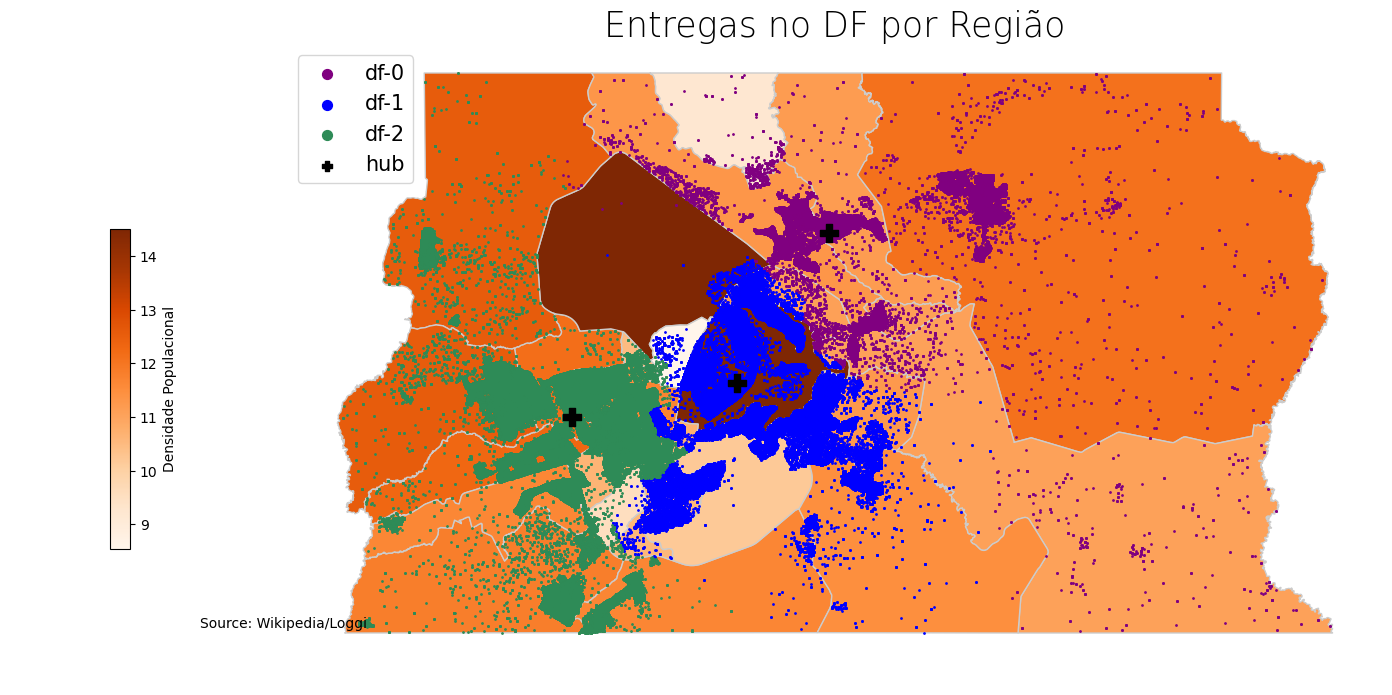

In [182]:
title = 'Entregas no DF por Região'
col = 'populacao'
source = 'Source: Wikipedia/Loggi'
vmin = mapa_populacao[col].min()
vmax = mapa_populacao[col].max()
cmap = 'Oranges'
# Create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(20, 8))
# Remove the axis
ax.axis('off')
mapa_populacao.plot(column=col, ax=ax, edgecolor='0.8', linewidth=1, cmap=cmap)

# Plotando as entregas
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color="purple", label="df-0")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color="blue", label="df-1")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color="seagreen", label="df-2")

# Plotando os hubs
geo_hub_df.plot(ax=ax, markersize=150, marker="P", color="black", label="hub")

lgnd = plt.legend(prop={"size": 15})
for handle in lgnd.legendHandles:
    handle.set_sizes([50])

# Add a title
ax.set_title(title, fontdict={'fontsize': '25', 'fontweight': '3'})
# Create an annotation for the data source
ax.annotate(source, xy=(0.1, .08), xycoords='figure fraction', horizontalalignment='left', 
            verticalalignment='bottom', fontsize=10)
            
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)
# Empty array for the data range
sm._A = []
# Add the colorbar to the figure
cbaxes = fig.add_axes([0.15, 0.25, 0.01, 0.4])
cbar = fig.colorbar(sm, cax=cbaxes, label="Densidade Populacional")

In [20]:
# Gráfico de entregas por região

# Agregação
data = pd.DataFrame(deliveries_df[['region', 'vehicle_capacity']].value_counts(normalize=True)).reset_index()
data.rename(columns={0: "region_percent"}, inplace=True)
data.head()

,region,vehicle_capacity,region_percent
0,df-1,180,0.478988
1,df-2,180,0.410783
2,df-0,180,0.110229


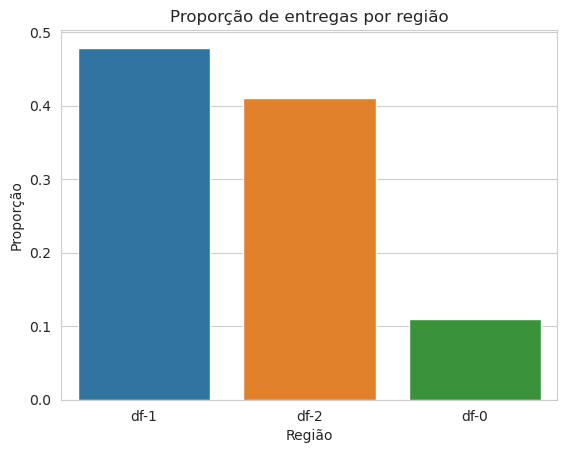

In [90]:
with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=data, x="region", y="region_percent", errorbar=None)
  grafico.set(title='Proporção de entregas por região', xlabel='Região', ylabel='Proporção');

In [52]:
deliveries_df_size = deliveries_df[['region', 'vehicle_capacity','delivery_size']]
deliveries_df_size.head()

,region,vehicle_capacity,delivery_size
0,df-2,180,9
1,df-2,180,2
2,df-2,180,1
3,df-2,180,2
4,df-2,180,7


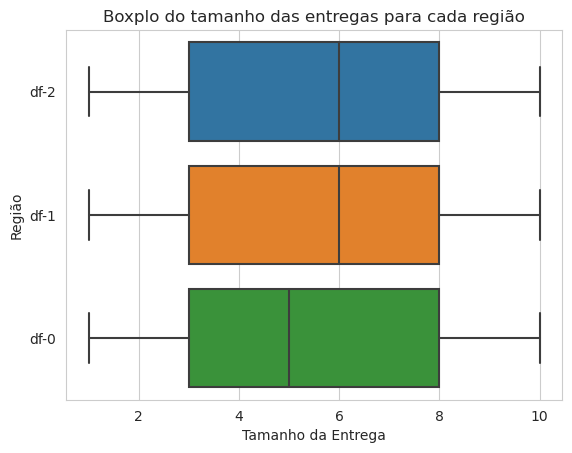

In [88]:
with sns.axes_style('whitegrid'):
  grafico = sns.boxplot(data=deliveries_df_size, x="delivery_size", y="region")
  grafico.set(title='Boxplot do tamanho das entregas para cada região', xlabel='Tamanho da Entrega', ylabel='Região');

## 5\. Insight

É possível observar que as entregas concentram-se em maior número na região central de Brasília. Os hubs, por sua vez, concentram-se em região central, ocupando desde a Asa Sul a Asa Norte. O local é estratégico, pois a maior quantidade de entregas acontecem nesta região.
É possível que a criação de dois novos hubs possam melhorar a logística de entregas, principalmente a Sudoeste e Nordeste do DF, visto que essas regiões apresentam um número alto de entregas e estão mais afastadas dos hubs.